In [2]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
import pylab as py
import random
import pandas as pd
from matplotlib import gridspec

# from calibTools import *

In [3]:
def Velocity_PDF(x, val, bin):
    
    N = len(val)
    for i in range(N):
        if bin[i]<=x and x<bin[i+1]:
            return val[i]
    return None

In [4]:
import matplotlib.ticker

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_orderOfMagnitude(self, nothing):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin, vmax):
        self.format = self.fformat
        if self._useMathText:
            self.format = '$%s$' % matplotlib.ticker._mathdefault(self.format)

In [5]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [6]:
alpha = -1
Ms = -22

## TF realtion parameters
slope = -8.34
zp = -20.80-0.04
rms = 0.49

In [7]:
def getLOGw(M, slope, zp):
    
    return 2.5+(M-zp)/slope

def getWrms(rms, dM, slope):
    
    return np.sqrt((rms**2-dM**2)/(slope**2))
    

def getM(logW, slope, zp):
    
    return slope*(logW-2.5)+zp
    

In [8]:
np.random.seed(0)

size = 30000

randMGAG = np.random.uniform(low=-24, high=-12, size=size)

randU = np.random.uniform(low=0, high=1, size=size)

randLfunct = LFfunction(randMGAG, Ms, alpha)

indx, = np.where(randU<randLfunct)

realM = randMGAG[indx]
realW = getLOGw(realM, slope, zp)

N = len(realM)

mag_scatter = np.zeros(N)
www_scatter = np.zeros(N)
for i in range(N):
    
    dM = np.random.uniform(low=0, high=rms)
    dW = getWrms(rms, dM, slope)
    
    mag_scatter[i]=np.random.normal(0, dM)
    www_scatter[i]=np.random.normal(0, dW)
    

scaterred_W = realW + www_scatter
intrinsic_M = realM + mag_scatter
predicted_M = getM(scaterred_W, slope, zp)

NameError: name 'LFfunction' is not defined

74884


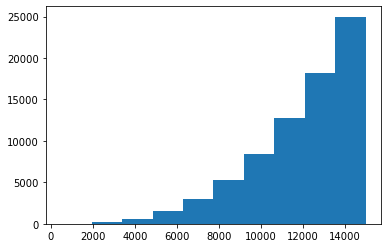

In [9]:
size = 300000

randU1 = np.random.uniform(low=0, high=1, size=size)
randU2 = np.random.uniform(low=0, high=4*np.pi/3., size=size)
indx, = np.where(randU2<(4*np.pi/3.)*randU1**3)

Vel = randU1[indx]*15000

plt.hist(Vel)

print(len(Vel))

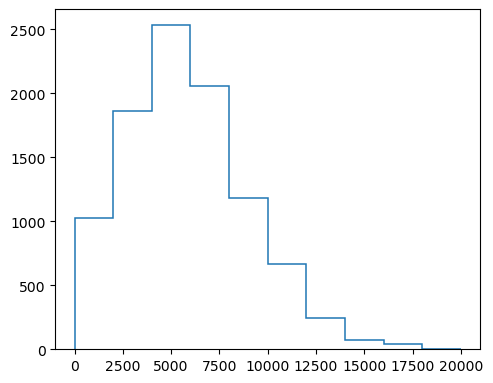

114606


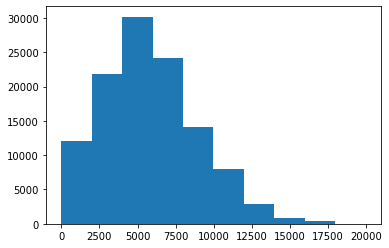

In [10]:
df = pd.read_csv('../CF4catalog/TFR_CF4_components_bar', delimiter='|')



# revising the column names
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)


df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.set_index('PGC')

fig = plt.figure(figsize=(5, 4), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
bins=np.arange(0,22000,2000)
val = df[df["DM_cf4"]!=0]["Vcmb"].values
param = ax.hist(val, bins=bins, histtype='step', label='cf4+'+str(len(val)), lw=1.1) 
val = param[0]
bin = param[1]

plt.show();


size = 300000

randU1 = np.random.uniform(low=0, high=20000, size=size)
y = np.asarray([Velocity_PDF(b, val, bin) for b in randU1])
randU2 = np.random.uniform(low=0, high=np.max(val), size=size)
indx, = np.where(randU2<y)

V_cf4 = randU1[indx]

plt.hist(V_cf4)

print(len(V_cf4))

In [11]:
s = 20000

# Vel      = Vel[:s]
Vel = V_cf4[:s]
intrinsic_M = intrinsic_M[:s]
predicted_M = predicted_M[:s]
scaterred_W = scaterred_W[:s]
realM = realM[:s]


H0 = 75
D = Vel/H0
logD = np.log10(D)
logV = np.log10(Vel)
DM = 5*logD+25

mag_i = intrinsic_M+DM
simulDM = mag_i-predicted_M    # linewidht -> predicted_M

simul_logH = logV - (simulDM-25)/5.


len(Vel)

NameError: name 'intrinsic_M' is not defined

In [ ]:
fig = py.figure(figsize=(5,3), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = mag_i
Y = 10**simul_logH

ax.plot(mag_i, Y, 'r.', alpha=0.01)

for i in np.arange(11,24,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')    
        
###################################################################

###################################################################        
        
x_ax, y_ax = set_axes(ax, (10,26), (35,150), fontsize=14) 
ax.set_yscale('log')

from matplotlib.ticker import MultipleLocator

from matplotlib.ticker import NullFormatter

ax.set_yticks(np.arange(30,150, step=30))
ax.yaxis.set_major_formatter(NullFormatter())  
ax.yaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_minor_locator(MultipleLocator(10))

plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))
# ax.set_yticks(np.arange(50,140, step=10))



y_ax.set_yticks(np.arange(30,150, step=30))
y_ax.set_yscale('log')
y_ax.yaxis.set_major_formatter(NullFormatter())  
y_ax.yaxis.set_minor_formatter(NullFormatter())
y_ax.yaxis.set_major_locator(MultipleLocator(30))
y_ax.yaxis.set_minor_locator(MultipleLocator(10))    

ax.set_ylabel(r'$H $'+'  [km/s/Mpc]', fontsize=14)
ax.set_xlabel(r'$i$'+ '  [mag]', fontsize=14)
ax.legend(loc=3)


ax.plot([5,26], [H0, H0], '--', color='k')

In [ ]:
fig = py.figure(figsize=(5,3), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = mag_i
Y = 10**simul_logH

# ax.plot(mag_i, Y, 'k.', alpha=0.01)

for i in np.arange(11,24,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')    
        
###################################################################
indx, = np.where(realM<-17)
X = mag_i[indx]
Y = 10**simul_logH[indx]

ax.plot(X, Y, 'b.', alpha=0.01)

for i in np.arange(11,24,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='b', ms=3)    
        
###################################################################        
        
x_ax, y_ax = set_axes(ax, (10,26), (35,150), fontsize=14) 
ax.set_yscale('log')

from matplotlib.ticker import MultipleLocator

from matplotlib.ticker import NullFormatter

ax.set_yticks(np.arange(30,150, step=30))
ax.yaxis.set_major_formatter(NullFormatter())  
ax.yaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_minor_locator(MultipleLocator(10))

plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))
# ax.set_yticks(np.arange(50,140, step=10))



y_ax.set_yticks(np.arange(30,150, step=30))
y_ax.set_yscale('log')
y_ax.yaxis.set_major_formatter(NullFormatter())  
y_ax.yaxis.set_minor_formatter(NullFormatter())
y_ax.yaxis.set_major_locator(MultipleLocator(30))
y_ax.yaxis.set_minor_locator(MultipleLocator(10))    

ax.set_ylabel(r'$H $'+'  [km/s/Mpc]', fontsize=14)
ax.set_xlabel(r'$i$'+ '  [mag]', fontsize=14)
ax.legend(loc=3)


ax.plot([5,26], [H0, H0], '--', color='k')

In [ ]:
fig = py.figure(figsize=(5,3), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = mag_i
Y = 10**simul_logH

# ax.plot(mag_i, Y, 'k.', alpha=0.01)

for i in np.arange(11,24,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')    
        
###################################################################
indx, = np.where(predicted_M<-17)
X = mag_i[indx]
Y = 10**simul_logH[indx]

ax.plot(X, Y, 'g.', alpha=0.01)

for i in np.arange(11,24,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='g', ms=3)    
        
###################################################################        
        
x_ax, y_ax = set_axes(ax, (10,26), (35,150), fontsize=14) 
ax.set_yscale('log')

from matplotlib.ticker import MultipleLocator

from matplotlib.ticker import NullFormatter

ax.set_yticks(np.arange(30,150, step=30))
ax.yaxis.set_major_formatter(NullFormatter())  
ax.yaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_minor_locator(MultipleLocator(10))

plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))
# ax.set_yticks(np.arange(50,140, step=10))



y_ax.set_yticks(np.arange(30,150, step=30))
y_ax.set_yscale('log')
y_ax.yaxis.set_major_formatter(NullFormatter())  
y_ax.yaxis.set_minor_formatter(NullFormatter())
y_ax.yaxis.set_major_locator(MultipleLocator(30))
y_ax.yaxis.set_minor_locator(MultipleLocator(10))    

ax.set_ylabel(r'$H $'+'  [km/s/Mpc]', fontsize=14)
ax.set_xlabel(r'$i$'+ '  [mag]', fontsize=14)
ax.legend(loc=3)


ax.plot([5,26], [H0, H0], '--', color='k')

In [ ]:
def Malmquist(DM, FIT, DM0=29.):
    
#     a = FIT[0]
#     b = FIT[1]
#     c = FIT[2]
#     d = FIT[3]
    
#     DM0 = 27 # 31
    X = DM-DM0
    if DM<DM0:
        return 0
    
    Y = 0
    N = len(FIT)
    for i in range(N):
        Y+= FIT[i]*X**(N-i)
    return Y
#     return a*X**4+b*X**3+c*X**2+d*X

def Malmquist_list(DM_list, FIT, DM0=29.):

    bias = DM_list*0
    for i, dm in enumerate(DM_list):
        bias[i] = Malmquist(dm, FIT,  DM0=DM0)
        
    
    return bias


In [ ]:
DM_Bias_i = Malmquist_list(simulDM, [ 0.00042138, -0.00373622,  0.011597,    0.00153675], DM0=29)

simul_logH_ = logV - (simulDM-25)/5.

In [ ]:
fig = py.figure(figsize=(5,3), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X = mag_i
Y = 10**simul_logH_

# ax.plot(mag_i, Y, 'k.', alpha=0.01)

for i in np.arange(11,24,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6, mfc='white')    
        
###################################################################
indx, = np.where(predicted_M<-17)
X = mag_i[indx]
Y = 10**simul_logH_[indx]

ax.plot(X, Y, 'g.', alpha=0.01)

for i in np.arange(11,24,1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='g', ms=3)    
        
###################################################################        
        
x_ax, y_ax = set_axes(ax, (10,26), (35,150), fontsize=14) 
ax.set_yscale('log')

from matplotlib.ticker import MultipleLocator

from matplotlib.ticker import NullFormatter

ax.set_yticks(np.arange(30,150, step=30))
ax.yaxis.set_major_formatter(NullFormatter())  
ax.yaxis.set_minor_formatter(NullFormatter())

ax.yaxis.set_major_locator(MultipleLocator(30))
ax.yaxis.set_minor_locator(MultipleLocator(10))

plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))
# ax.set_yticks(np.arange(50,140, step=10))



y_ax.set_yticks(np.arange(30,150, step=30))
y_ax.set_yscale('log')
y_ax.yaxis.set_major_formatter(NullFormatter())  
y_ax.yaxis.set_minor_formatter(NullFormatter())
y_ax.yaxis.set_major_locator(MultipleLocator(30))
y_ax.yaxis.set_minor_locator(MultipleLocator(10))    

ax.set_ylabel(r'$H $'+'  [km/s/Mpc]', fontsize=14)
ax.set_xlabel(r'$i$'+ '  [mag]', fontsize=14)
ax.legend(loc=3)


ax.plot([5,26], [H0, H0], '--', color='k')

In [ ]:
# Vel = V_cf4[:s]
# intrinsic_M = intrinsic_M[:s]
# predicted_M = predicted_M[:s]
# scaterred_W = scaterred_W[:s]
# realM = realM[:s]


In [ ]:
indx = np.where((mag_i<18) & (scaterred_W>2.))

In [ ]:
np.max(Vel)

In [ ]:
plt.plot(scaterred_W[indx], -1*intrinsic_M[indx], 'k.', alpha=0.01)

In [ ]:
plt.plot(Vel[indx], -1*intrinsic_M[indx], 'k.', alpha=0.05)